In [285]:
# import required modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import collections
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [162]:
data = pd.read_csv("~/../../mnt/c/Users/Ethan/Downloads/archive/hacker_news_sample.csv")
data

,title,url,text,dead,by,score,time,type,id,parent,descendants,ranking,deleted,timestamp
0,NaN,NaN,&gt;<i>which leads me to say why are you using...,NaN,coldtea,NaN,1.390844e+09,comment,7131680,7127578.0,NaN,NaN,NaN,2014-01-27T17:31:13Z
1,NaN,NaN,I would like to point out some counter-example...,NaN,etanol,NaN,1.319396e+09,comment,3146879,3145330.0,NaN,NaN,NaN,2011-10-23T18:46:40Z
2,NaN,NaN,NaN,NaN,NaN,NaN,1.456641e+09,comment,11190089,11189361.0,NaN,NaN,True,2016-02-28T06:26:56Z
3,NaN,NaN,<i>Our msbuild implementation can now build Pr...,NaN,Locke1689,NaN,1.407882e+09,comment,8170491,8170071.0,NaN,NaN,NaN,2014-08-12T22:13:10Z
4,NaN,NaN,No matter how awful iPhoto is it's still bette...,NaN,miloshadzic,NaN,1.362573e+09,comment,5330773,5327590.0,NaN,NaN,NaN,2013-03-06T12:28:02Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659692,NaN,NaN,"They are still on book #79 ""Mystery of the Sac...",NaN,mynameishere,NaN,1.189823e+09,comment,54809,54631.0,NaN,NaN,NaN,2007-09-15T02:31:03Z
3659693,NaN,NaN,I&#x27;d argue rather it&#x27;s copyright law ...,NaN,ajarmst,NaN,1.434245e+09,comment,9713452,9711891.0,NaN,NaN,NaN,2015-06-14T01:23:00Z
3659694,NaN,NaN,that&#x27;s my startup! boom,True,woah,NaN,1.378690e+09,comment,6351340,6351046.0,NaN,NaN,NaN,2013-09-09T01:23:08Z
3659695,NaN,NaN,For one there&#x27;s less worry that you&#x27;...,NaN,aqme28,NaN,1.425258e+09,comment,9129747,9129736.0,NaN,NaN,NaN,2015-03-02T01:07:19Z


In [163]:
# get number of stories and comments
d2 = data.copy()
num_story = d2.loc[d2.type == "story", "type"].count()
num_comment = d2.loc[d2.type == "comment", "type"].count()
print(num_story, num_comment)

653757 3000341


In [164]:
# group data by score
d3 = d2.loc[d2.type == "story"]
score_freq = d3.groupby(["score"], sort = True)["score"].count().reset_index(name='frequency')

/tmp/ipykernel_985/3223394518.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d4.frequency = np.log(d4.frequency)


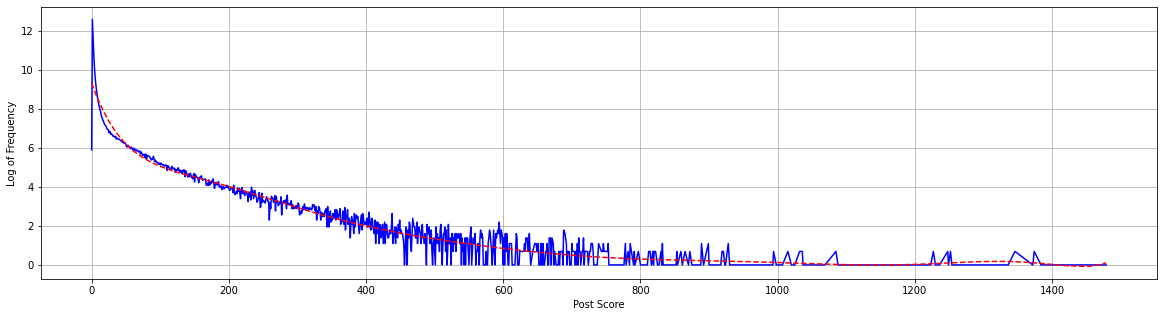

In [165]:
# plot direct distribution of scores

d4 = score_freq.loc[score_freq.score < 1500]
d4.frequency = np.log(d4.frequency)
x_axis = d4.score
y_axis = d4.frequency
plt.figure(figsize = (20, 5))
plt.plot(x_axis, y_axis, "b")
plt.grid()
z = np.polyfit(x_axis, y_axis, 10)
p = np.poly1d(z)
plt.plot(x_axis,p(x_axis),"r--")
plt.xlabel("Post Score")
plt.ylabel("Log of Frequency")
plt.show()

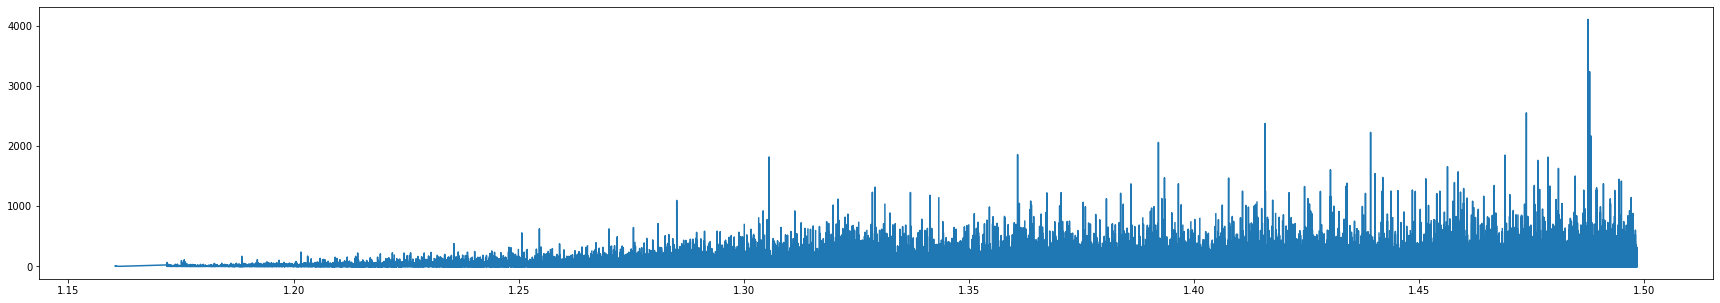

In [166]:
# group score over time

d5 = d2.loc[d2.type == "story"]
score_over_time = d5.groupby(["time"])["score"].mean().reset_index(name='average_score')
score_over_time["time"] = score_over_time["time"] / np.power(10,9)
plt.figure(figsize = (30, 5))
plt.plot(score_over_time["time"], score_over_time["average_score"])
plt.show()

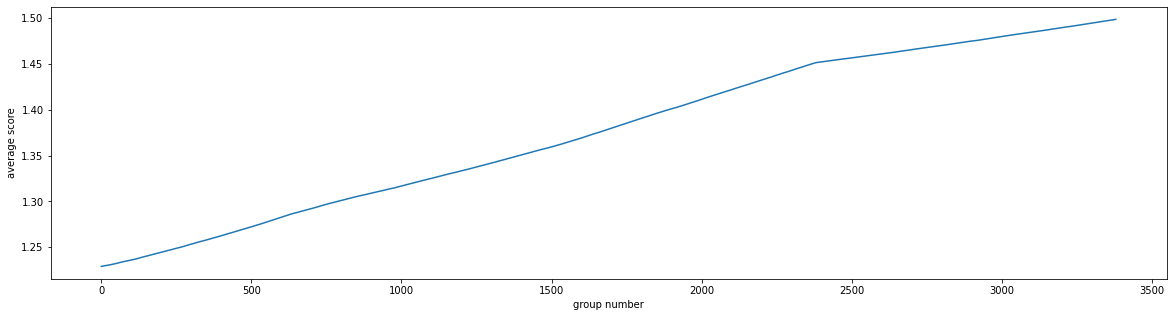

In [167]:
# combine unix times into groups
score_over_time
group_size = 0.0001
bottom = score_over_time["time"].min()
group_score = 0
group_count = 0
groups = []
i = bottom
while i <= score_over_time["time"].max():
    group_score = 0
    group_count = 0
    for time in score_over_time["time"]:
        if time < i:
            continue
        elif time > i + 0.1:
            break
        else:
            group_score += time
            group_count += 1
    groups.append(group_score / group_count)
    i += group_size

plt.figure(figsize = (20, 5))
plt.plot(np.arange(len(groups)), groups)
plt.xlabel("group number")
plt.ylabel("average score")
plt.show()

In [168]:
# convert unix timestamps to datetime
def convert_time_to_date(times):
    for i in times.index:
        if times[i] > 0:
            times[i] = datetime.datetime.fromtimestamp(times[i])
    return times

stories = d2.loc[d2["type"] == "story"]
stories = stories.loc[stories["time"] > 0]
times = stories["time"]
new_times = convert_time_to_date(times)
data_with_dates = stories.copy()
data_with_dates["time"] = new_times


/tmp/ipykernel_985/2593301848.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  times[i] = datetime.datetime.fromtimestamp(times[i])


In [169]:
# group by day
grouped_by_dates = data_with_dates[["time", "score"]]
resampled_dates_on_day = grouped_by_dates.resample('D', on ="time")
avg_score_per_day = resampled_dates_on_day.mean()
total_score_per_day = resampled_dates_on_day.sum()
print(avg_score_per_day)
print(total_score_per_day)

                score
time                 
2006-10-09   7.333333
2006-10-10   1.000000
2006-10-11   4.250000
2006-10-12   4.000000
2006-10-13        NaN
...               ...
2017-06-22  11.376119
2017-06-23   9.418868
2017-06-24  11.216049
2017-06-25  11.259542
2017-06-26   7.863636

[3914 rows x 1 columns]
             score
time              
2006-10-09    22.0
2006-10-10     1.0
2006-10-11    17.0
2006-10-12     4.0
2006-10-13     0.0
...            ...
2017-06-22  3811.0
2017-06-23  2496.0
2017-06-24  1817.0
2017-06-25  1475.0
2017-06-26   519.0

[3914 rows x 1 columns]


In [170]:
print(avg_score_per_day["score"].keys())
print(avg_score_per_day["score"].values)
print(len(avg_score_per_day["score"].values))

DatetimeIndex(['2006-10-09', '2006-10-10', '2006-10-11', '2006-10-12',
               '2006-10-13', '2006-10-14', '2006-10-15', '2006-10-16',
               '2006-10-17', '2006-10-18',
               ...
               '2017-06-17', '2017-06-18', '2017-06-19', '2017-06-20',
               '2017-06-21', '2017-06-22', '2017-06-23', '2017-06-24',
               '2017-06-25', '2017-06-26'],
              dtype='datetime64[ns]', name='time', length=3914, freq='D')
[ 7.33333333  1.          4.25       ... 11.21604938 11.25954198
  7.86363636]
3914


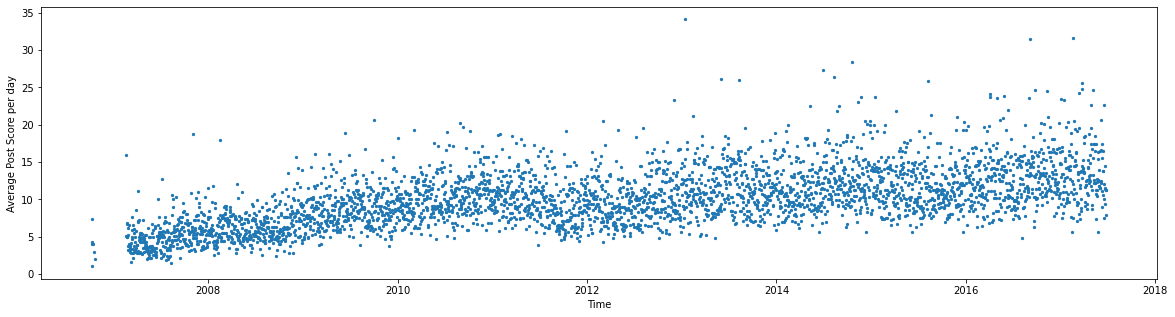

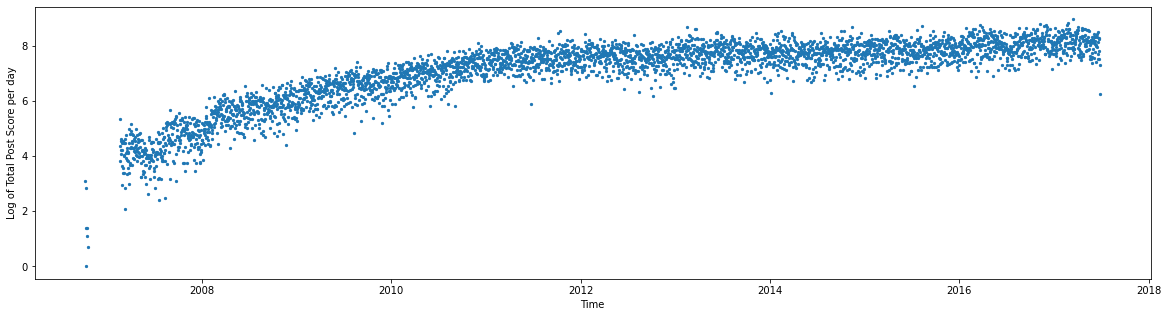

In [212]:
# remove NaN 

avg_score_per_day = avg_score_per_day.dropna()
total_score_per_day = total_score_per_day.dropna()

plt.figure(figsize = (20, 5))
plt.scatter(avg_score_per_day["score"].keys(), avg_score_per_day["score"], s = 5)
plt.xlabel("Time")
plt.ylabel("Average Post Score per day")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(total_score_per_day["score"].keys(), np.log(total_score_per_day["score"]), s = 5)
plt.xlabel("Time")
plt.ylabel("Log of Total Post Score per day")
plt.show()

In [172]:
resampled_dates_on_month = grouped_by_dates.resample('M', on ="time")
resampled_dates_on_year = grouped_by_dates.resample('Y', on ="time")
avg_score_per_month = resampled_dates_on_month.mean()
total_score_per_month = resampled_dates_on_month.sum()
avg_score_per_year = resampled_dates_on_year.mean()
total_score_per_year = resampled_dates_on_year.sum()

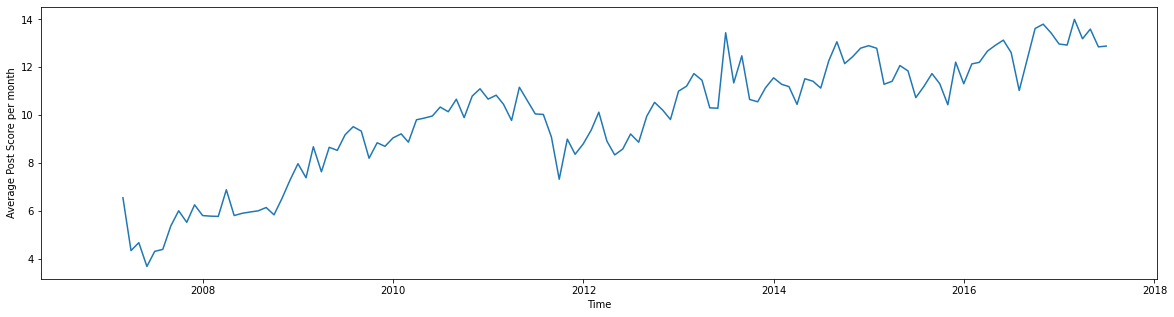

/home/zaidek/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


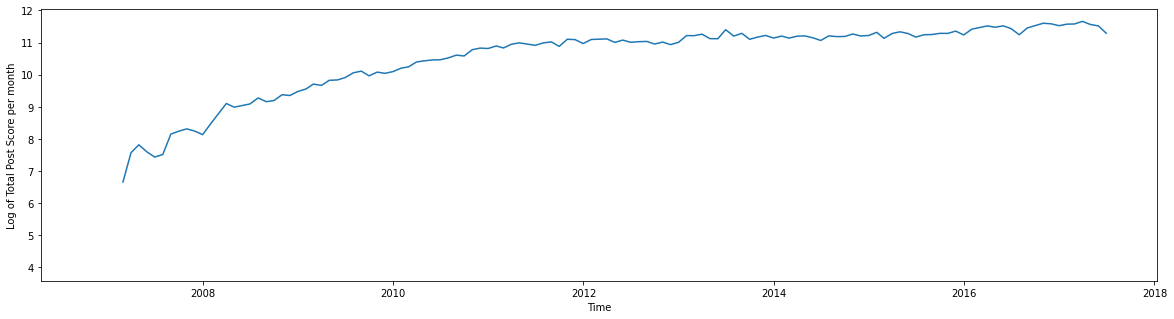

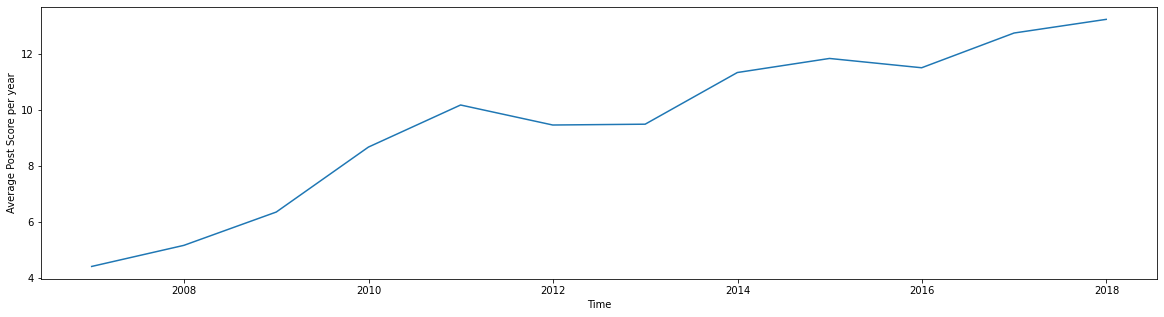

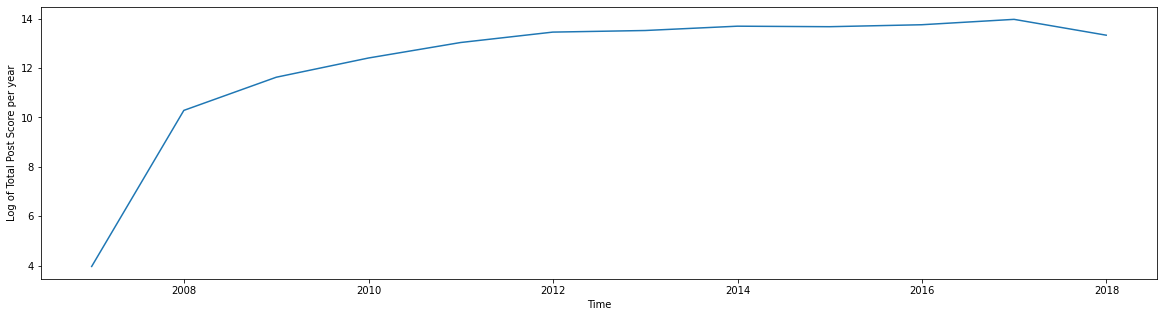

In [173]:
plt.figure(figsize = (20, 5))
plt.plot(avg_score_per_month["score"].keys(), avg_score_per_month["score"])
plt.xlabel("Time")
plt.ylabel("Average Post Score per month")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(total_score_per_month["score"].keys(), np.log(total_score_per_month["score"]))
plt.xlabel("Time")
plt.ylabel("Log of Total Post Score per month")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(avg_score_per_year["score"].keys(), avg_score_per_year["score"])
plt.xlabel("Time")
plt.ylabel("Average Post Score per year")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(total_score_per_year["score"].keys(), np.log(total_score_per_year["score"]))
plt.xlabel("Time")
plt.ylabel("Log of Total Post Score per year")
plt.show()

In [174]:
training_data_rand = data.sample(frac = 0.7, random_state=25)
testing_data_rand = data.drop(training_data_rand.index)

training_data_cutoff = data_with_dates.loc[data_with_dates["time"] <= datetime.datetime(2015, 1, 1)]
testing_data_cutoff = data_with_dates.drop(training_data_cutoff.index)

print(training_data_cutoff["time"])
print(testing_data_cutoff["time"])


6          2014-03-18 21:44:46
7          2012-11-19 11:54:38
22         2010-12-16 18:27:09
58         2008-03-21 17:14:08
69         2012-08-22 11:21:32
                  ...         
3659638    2014-08-14 22:00:37
3659655    2012-08-30 04:47:08
3659664    2014-04-11 09:12:08
3659683    2011-02-25 19:46:30
3659687    2014-01-25 21:25:46
Name: time, Length: 418753, dtype: object
8          2016-11-04 13:55:30
17         2015-02-24 17:42:09
20         2016-06-04 21:16:27
33         2017-05-15 15:43:38
37         2016-04-13 13:33:15
                  ...         
3659640    2015-07-15 22:24:36
3659653    2015-09-28 21:17:58
3659658    2015-11-04 16:11:06
3659668    2015-02-10 03:04:21
3659696    2015-04-19 14:15:38
Name: time, Length: 228287, dtype: object


In [175]:
print(len(training_data_rand))
print(len(testing_data_rand))

2561788
1097909


In [176]:
training_score_freq = training_data_rand.groupby(["score"], sort = True)["score"].count().reset_index(name='frequency')
training_score_freq_2 = training_data_cutoff.groupby(["score"], sort = True)["score"].count().reset_index(name='frequency')

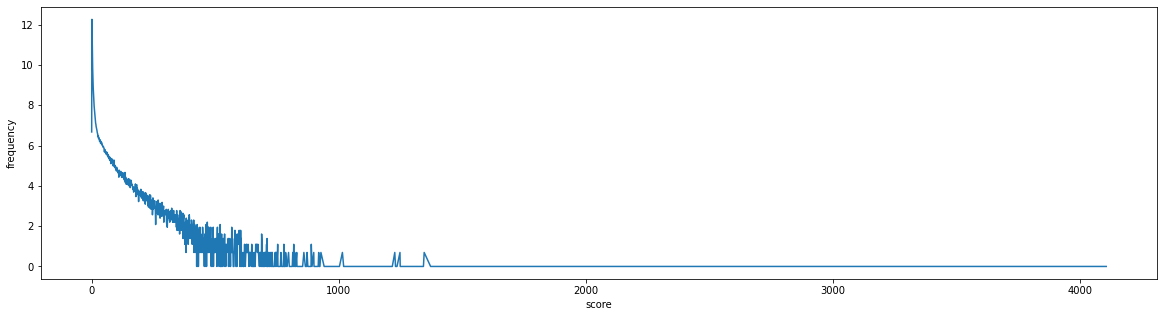

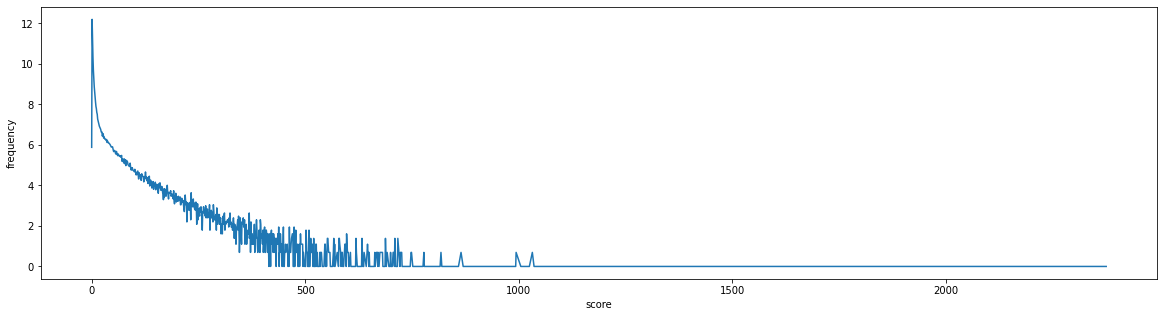

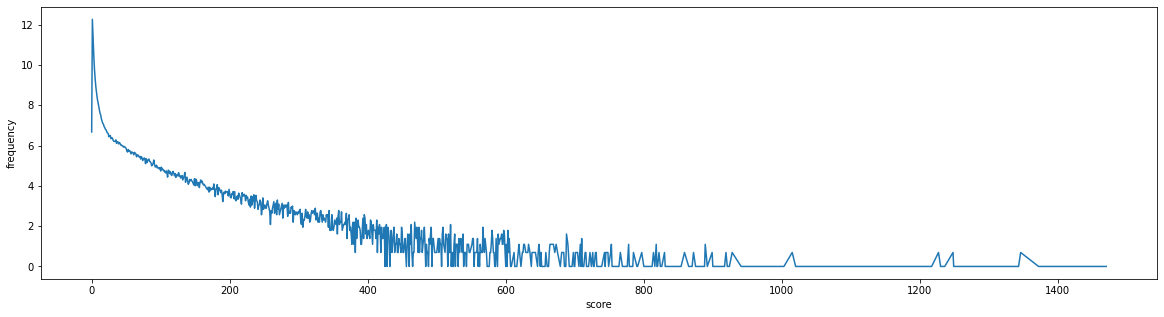

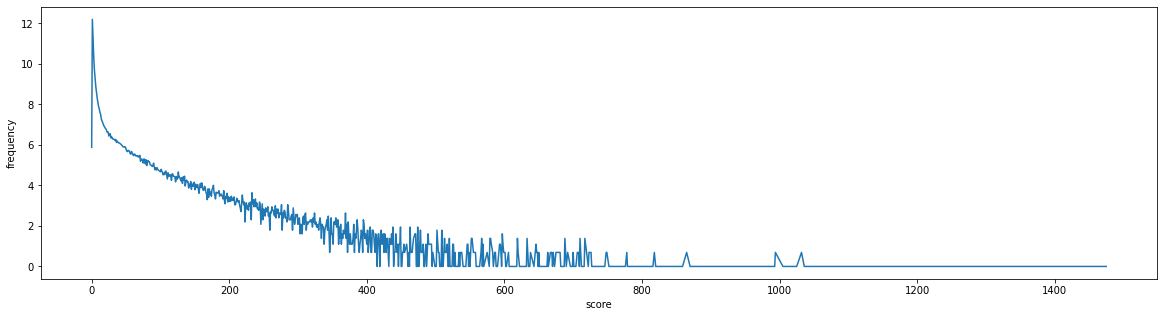

In [177]:
plt.figure(figsize = (20, 5))
plt.plot(training_score_freq["score"], np.log(training_score_freq["frequency"]))
plt.xlabel("score")
plt.ylabel("frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(training_score_freq_2["score"], np.log(training_score_freq_2["frequency"]))
plt.xlabel("score")
plt.ylabel("frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(training_score_freq.loc[training_score_freq["score"] <= 1500]["score"], np.log(training_score_freq.loc[training_score_freq["score"] <= 1500]["frequency"]))
plt.xlabel("score")
plt.ylabel("frequency")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(training_score_freq_2.loc[training_score_freq_2["score"] <= 1500]["score"], np.log(training_score_freq_2.loc[training_score_freq_2["score"] <= 1500]["frequency"]))
plt.xlabel("score")
plt.ylabel("frequency")
plt.show()

In [178]:
old_times_1 = training_data_rand["time"].dropna()

print(old_times_1)

new_times_1 = convert_time_to_date(old_times_1)


training_data_rand["dates"] = new_times_1
training_data_cutoff["dates"] = training_data_cutoff["time"]

training_data_rand

1751819    1.348234e+09
1805524    1.304883e+09
2086997    1.234710e+09
1993546    1.309968e+09
3330835    1.192718e+09
               ...     
1080276    1.341296e+09
2252208    1.467493e+09
1653743    1.343853e+09
3265424    1.467600e+09
2652054    1.412780e+09
Name: time, Length: 2557086, dtype: float64


/tmp/ipykernel_985/1471643089.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data_cutoff["dates"] = training_data_cutoff["time"]


,title,url,text,dead,by,score,time,type,id,parent,descendants,ranking,deleted,timestamp,dates
1751819,NaN,NaN,Maybe that's the key to making a good product ...,NaN,aswanson,NaN,1.348234e+09,comment,4553599,4551896.0,NaN,NaN,NaN,2012-09-21T13:19:47Z,2012-09-21 14:19:47
1805524,Not sure if this is legal for US citizens but ...,https://betco.in,NaN,NaN,dickchaninin,3.0,1.304883e+09,story,2526540,NaN,0.0,NaN,NaN,2011-05-08T19:28:41Z,2011-05-08 20:28:41
2086997,NaN,NaN,You don't get much value out of Twitter if you...,NaN,petercooper,NaN,1.234710e+09,comment,481994,480507.0,NaN,NaN,NaN,2009-02-15T14:54:31Z,2009-02-15 14:54:31
1993546,NaN,NaN,Perhaps it's not that different than how chari...,NaN,spudlyo,NaN,1.309968e+09,comment,2734473,2734434.0,NaN,NaN,NaN,2011-07-06T15:59:54Z,2011-07-06 16:59:54
3330835,NaN,NaN,Thanks for nice input,NaN,Jaggu,NaN,1.192718e+09,comment,69680,69412.0,NaN,NaN,NaN,2007-10-18T14:28:00Z,2007-10-18 15:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080276,Twitter employee live tweets WSOP from the table,https://twitter.com/#!/chanian,NaN,NaN,jhspaybar,9.0,1.341296e+09,story,4192793,NaN,0.0,NaN,NaN,2012-07-03T06:15:32Z,2012-07-03 07:15:32
2252208,Deep-learning vision system anticipates human ...,http://phys.org/news/2016-06-deep-learning-vis...,NaN,NaN,Lind5,2.0,1.467493e+09,story,12023752,NaN,0.0,NaN,NaN,2016-07-02T20:51:58Z,2016-07-02 21:51:58
1653743,NaN,NaN,Love the idea.. Possibilities around POS data ...,NaN,mthmohan,NaN,1.343853e+09,comment,4325504,4325317.0,NaN,NaN,NaN,2012-08-01T20:33:11Z,2012-08-01 21:33:11
3265424,NaN,NaN,A plane can depending on the airport start fly...,NaN,DasIch,NaN,1.467600e+09,comment,12028675,12028547.0,NaN,NaN,NaN,2016-07-04T02:45:42Z,2016-07-04 03:45:42


In [267]:
time_mean_rand = training_data_rand[["dates", "score"]]
time_mean_rand = time_mean_rand.dropna()
score_over_hours = time_mean_rand.groupby(lambda x : time_mean_rand["dates"][x].hour)["score"]
score_over_minutes = time_mean_rand.groupby(lambda x : datetime.time(time_mean_rand["dates"][x].hour, time_mean_rand["dates"][x].minute))["score"]

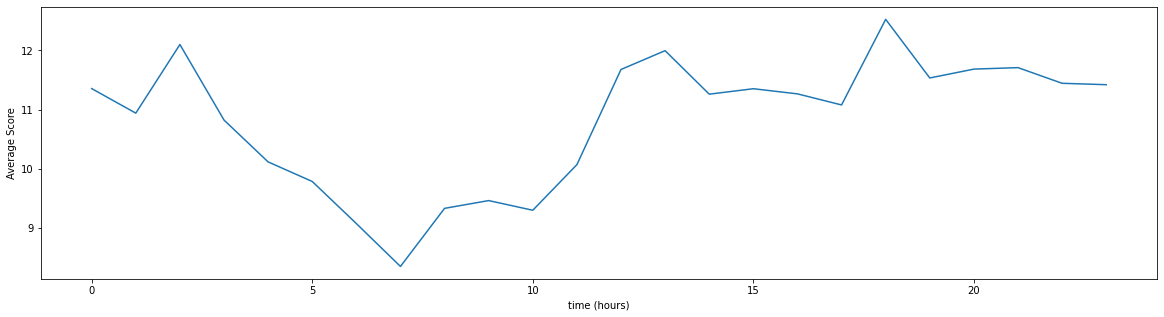

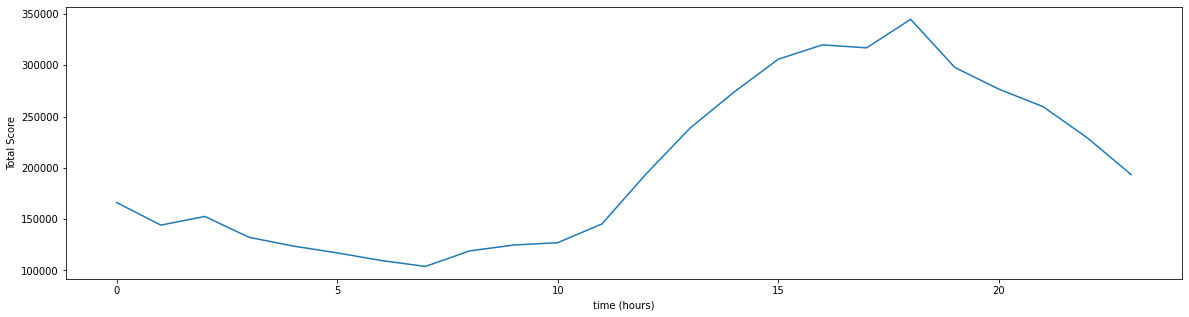

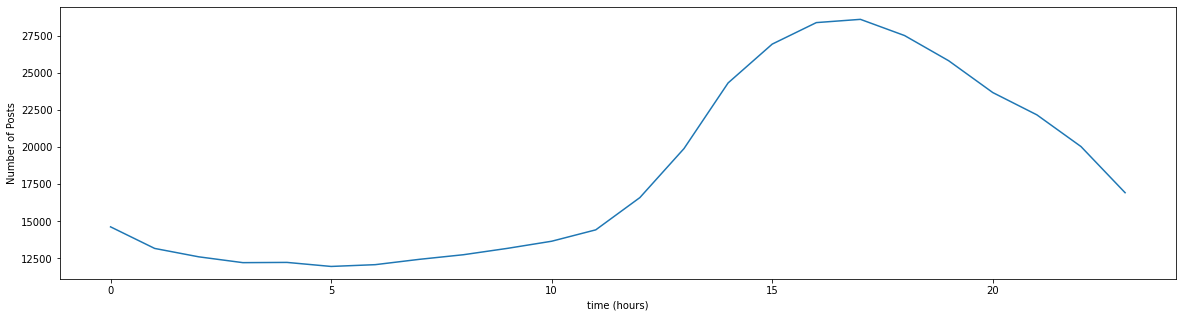

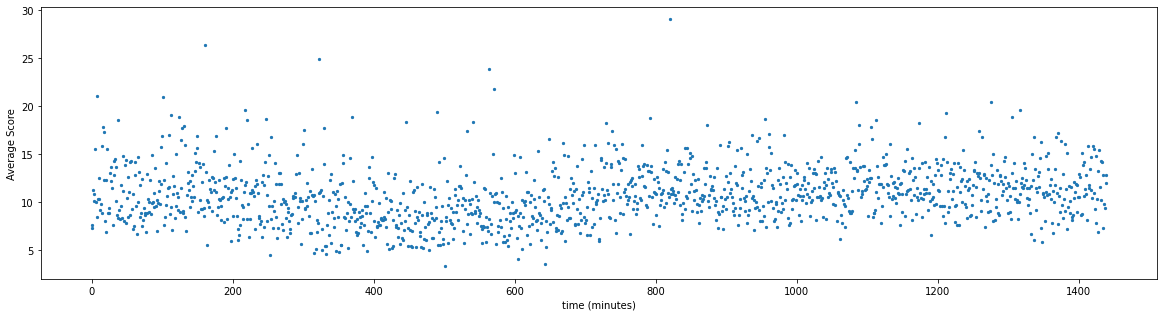

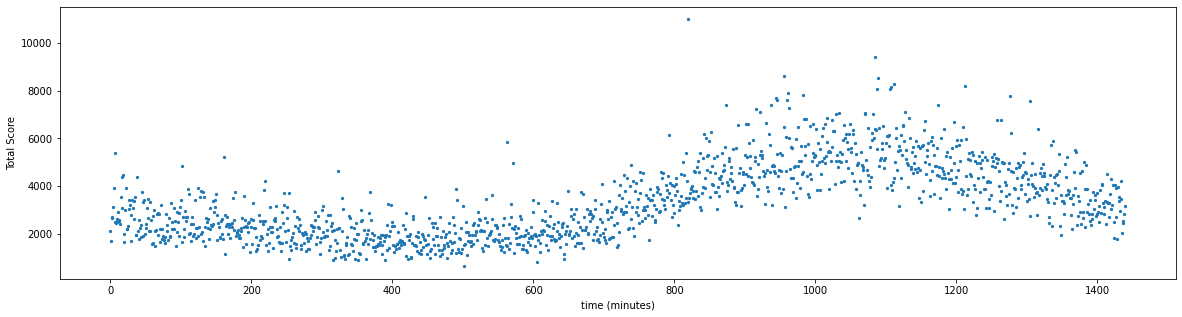

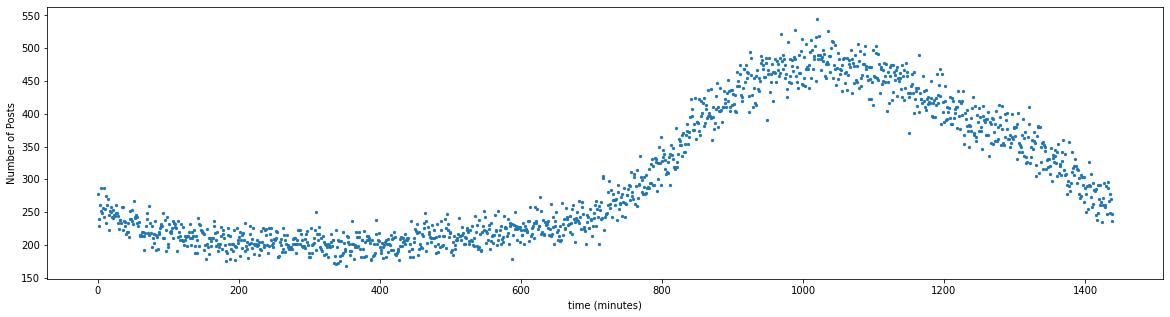

In [269]:
score_over_hours_mean = score_over_hours.mean()
score_over_hours_total = score_over_hours.sum()
score_over_hours_count = score_over_hours.count()
score_over_minutes_mean = score_over_minutes.mean()
score_over_minutes_total = score_over_minutes.sum()
score_over_minutes_count = score_over_minutes.count()

plt.figure(figsize = (20, 5))
plt.plot(score_over_hours_mean.keys(), score_over_hours_mean.values)
plt.xlabel("time (hours)")
plt.ylabel("Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_over_hours_total.keys(), score_over_hours_total.values)
plt.xlabel("time (hours)")
plt.ylabel("Total Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.plot(score_over_hours_count.keys(), score_over_hours_count.values)
plt.xlabel("time (hours)")
plt.ylabel("Number of Posts")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(np.arange(len(score_over_minutes_mean.keys())), score_over_minutes_mean.values, s = 5)
plt.xlabel("time (minutes)")
plt.ylabel("Average Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(np.arange(len(score_over_minutes_total.keys())), score_over_minutes_total.values, s = 5)
plt.xlabel("time (minutes)")
plt.ylabel("Total Score")
plt.show()

plt.figure(figsize = (20, 5))
plt.scatter(np.arange(len(score_over_minutes_count.keys())), score_over_minutes_count.values, s = 5)
plt.xlabel("time (minutes)")
plt.ylabel("Number of Posts")
plt.show()

In [294]:
stop_words = set(stopwords.words('english'))

training_data_rand_stories = training_data_rand.loc[training_data_rand.type == "story"]
training_data_rand_stories_text = training_data_rand_stories["text"].dropna()
print("would" in stop_words)
Counter([w for w in " ".join(training_data_rand_stories_text.str.lower()).split() if w not in stop_words]).most_common(100)


False


[('would', 10859),
 ('like', 10312),
 ('get', 7948),
 ('-', 7081),
 ('one', 6707),
 ('people', 6273),
 ('new', 6003),
 ('know', 5924),
 ('time', 5625),
 ('work', 5336),
 ('want', 5201),
 ('use', 5151),
 ("i'm", 5036),
 ('also', 4785),
 ('good', 4503),
 ('make', 4495),
 ('web', 4389),
 ('find', 4214),
 ('looking', 4131),
 ('i&#x27;m', 4121),
 ('could', 3941),
 ('need', 3936),
 ('think', 3847),
 ('really', 3775),
 ('best', 3722),
 ('company', 3606),
 ('many', 3566),
 ('help', 3427),
 ('something', 3417),
 ('app', 3401),
 ('way', 3393),
 ('using', 3370),
 ('much', 3312),
 ('online', 3191),
 ('us', 3184),
 ('see', 3151),
 ('free', 3147),
 ('working', 3135),
 ('anyone', 3031),
 ('business', 3023),
 ('even', 3015),
 ('first', 2906),
 ('software', 2847),
 ('site', 2812),
 ('experience', 2657),
 ('data', 2573),
 ("i've", 2537),
 ('go', 2526),
 ('hn', 2522),
 ('startup', 2502),
 ('things', 2447),
 ('years', 2434),
 ('lot', 2403),
 ('great', 2401),
 ('take', 2387),
 ('google', 2386),
 ('idea', 2